We start with a simple ODE:

$$\dfrac{dx}{dt}=\lambda x, x(t=t_0)=x_0$$

This problem can be formulated as a machine learning problem where the training examples are

$$(t_i, \lambda x_i), i \in \{1, 2, ..., N\}$$

and the loss function is

$$\mathcal{L}(\text{NN})=(\dfrac{dx}{dt}-\lambda x)^2$$

where NN is the transformation learned by a neural network. We can enforce the initial condition $x(t=t_0)=x_0$ by setting

$$x = x_0 + (t-t_0)\text{NN}(t)$$

at the output layer of the network.

In [1]:
import torch
import torch.nn            as nn
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt
%matplotlib inline

In [2]:
class FCNN(nn.Module):
    def __init__(self, hidden_units, initial_conidtion, lambda_):
        super(FCNN, self).__init__()
        self.t0, self.x0 = initial_conidtion
        self.lambda_ = lambda_
        self.fc1 = nn.Linear(1, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, t):
        x = torch.relu(self.fc1(t))
        x = torch.relu(self.fc2(x))
        x = self.x0 + (t-self.t0)*x
        return x

In [3]:
# generate training examples before training

# def train(fcnn, t_in_batches, optimizer, criterion, n_epochs):
#     for epoch in range(n_epochs):
#         for t_in in t_in_batches:
#             optimizer.zero_grad()
            
#             x_out = fcnn(t_in)
#             dxdt_true = x_out * fcnn.lambda_
#             dxdt = autograd.grad(x_out, t_in, create_graph=True, 
#                                  grad_outputs=torch.ones_like(dxdt_true))[0]
#             loss = criterion(dxdt, dxdt_true)
#             loss.backward()
            
#             optimizer.step()

# # solve for dx/dt = x, x(t=0) = 1
# fcnn = FCNN(hidden_units=100, initial_conidtion=(0.0, 1.0), lambda_=1)
# # 100 batches, each with a single 1-dimensional example 
# t_in_batches = torch.linspace(0, 1, 100, requires_grad=True).reshape(10, 10, 1) 
# optimizer = optim.SGD(fcnn.parameters(), lr=0.01)
# criterion = nn.MSELoss()

# train(fcnn, t_in_batches, optimizer=optimizer, criterion=criterion, n_epochs=10)

# ts = t_in_batches.detach().numpy().flatten()
# xs = fcnn(t_in_batches).detach().numpy().flatten()
# plt.plot(ts, xs,         label='x(t) by NN')
# plt.plot(ts, np.exp(ts), label='x(t)')
# plt.legend();

In [4]:
class TrainingExampleGenerator:
    def __init__(self, t_min, t_max):
        self.scale = t_max - t_min
        self.t_min = t_min
        
    def get_t_in(self, batch_size):
        return torch.rand((batch_size, 1), requires_grad=True)*self.scale + self.t_min

In [5]:
def train_gen(fcnn, t_gen, optimizer, criterion, n_examples, n_epochs, batch_size):
    loss_history = []
    for epoch in range(n_epochs):
        for batch in range(n_examples//batch_size):
            optimizer.zero_grad()
            
            t_in  = t_gen.get_t_in(batch_size)
            x_out = fcnn(t_in)
            dxdt_true = x_out * fcnn.lambda_
            dxdt      = autograd.grad(x_out, t_in, create_graph=True, 
                                      grad_outputs=torch.ones_like(dxdt_true))[0]
            loss = criterion(dxdt, dxdt_true)
            loss_history.append(loss)
            loss.backward()
            
            optimizer.step()
    return loss_history

In [6]:
lambda_       = 1.0
t_0,   x_0   =  0.0, 1.0
t_min, t_max = -1.0, 1.0

# solve for dx/dt = x, x(t=0) = 1
fcnn = FCNN(hidden_units=100, initial_conidtion=(t_0, x_0), lambda_=lambda_)
# generate training examples in the range (t_min, t_max)
t_gen = TrainingExampleGenerator(t_min, t_max)
optimizer = optim.SGD(fcnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

loss_history = train_gen(fcnn, t_gen, optimizer=optimizer, criterion=criterion, 
                         n_examples=1024, n_epochs=8, batch_size=64)

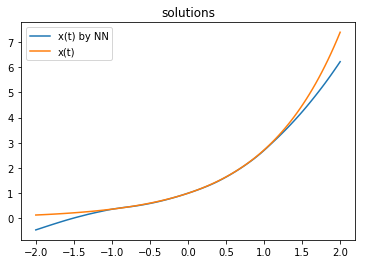

In [7]:
plot_t_min, plot_t_max = t_min-1, t_max+1

ts = np.linspace(plot_t_min, plot_t_max, 100)
xs = fcnn( torch.linspace(plot_t_min, plot_t_max, 100).reshape((-1, 1, 1)) )\
     .detach().numpy().flatten()
plt.plot(ts, xs,                     label='x(t) by NN')
plt.plot(ts, x_0*np.exp(lambda_*ts), label='x(t)')
plt.legend()
plt.title('solutions')
plt.show()

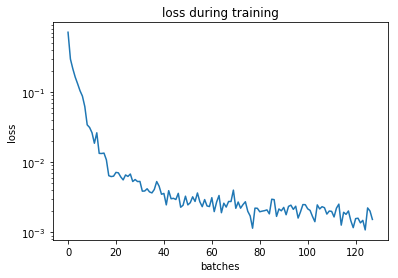

In [8]:
plt.plot(loss_history)
plt.title('loss during training')
plt.ylabel('loss')
plt.xlabel('batches')
plt.yscale('log')
plt.show()

The code is still broken:
* Activation function: relu sometimes gives a flat line, sigmoid seems to converge slowly (deminishing gradient?)
* Using t_in=linspace(0, 3, 100) or linspace(-1, 1, 100) gives flat line (something wrong with weight initialization?)